In [3]:
import keras_tuner
import pandas as pd
import math
import keras
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

In [6]:

rows_to_skip=16
rows_to_read=8760
X_data=pd.read_csv('TMYPalma.csv',skiprows=rows_to_skip,nrows=rows_to_read,parse_dates=['time(UTC)'],index_col='time(UTC)')
X_data.index=pd.to_datetime(X_data.index, format='%Y%m%d:%H%M')
X_data=X_data.drop(columns=['Gb(n)', 'Gd(h)','IR(h)'])
X_data=X_data.rename(columns={"T2m":"temp","RH":"humidity","G(h)":"irradiance","WS10m":"speed","WD10m":"deg","SP":"pressure"})
X_data['Hour']=X_data.index.hour
X_data['Month']=X_data.index.month
X_data.index = X_data.index.map(lambda x: x.replace(year=2014))

In [9]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.datasets import fashion_mnist

In [10]:
#loading the data
(X_train,y_train),(X_test,y_test)=fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


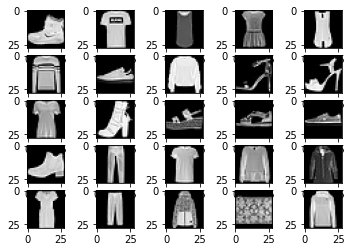

In [11]:
#visualizing the dataset
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [12]:
#normalizing the images
X_train=X_train/255
X_test=X_test/255

In [13]:
model=Sequential([
    #flattening the images
    Flatten(input_shape=(28,28)),
    #adding first hidden layer
    Dense(256,activation='relu'),
    #adding second hidden layer
    Dense(128,activation='relu'),
    #adding third hidden layer
    Dense(64,activation='relu'),
    #adding output layer
    Dense(10,activation='softmax')
])

In [14]:
#compiling the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting the model
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4858 - accuracy: 0.8245
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3627 - accuracy: 0.8663
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3272 - accuracy: 0.8797
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3059 - accuracy: 0.8865
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2900 - accuracy: 0.8921
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2763 - accuracy: 0.8964
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2606 - accuracy: 0.9014
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2486 - accuracy: 0.9059
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2402 - accuracy: 0.9101
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.23

In [15]:
#evaluating the model
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3519 - accuracy: 0.8768


[0.3518812358379364, 0.876800000667572]

In [16]:
def build_model(hp):          #hp means hyper parameters
    model=Sequential()
    model.add(Flatten(input_shape=(28,28)))
    #providing range for number of neurons in a hidden layer
    model.add(Dense(units=hp.Int('num_of_neurons',min_value=32,max_value=512,step=32),
                                    activation='relu'))
    #output layer
    model.add(Dense(10,activation='softmax'))
    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [17]:
#feeding the model and parameters to Random Search
tuner=RandomSearch(build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner1',
    project_name='Clothing')

In [18]:
#this tells us how many hyperparameter we are tuning
#in our case it's 2 = neurons,learning rate
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_of_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [19]:
#fitting the tuner on train dataset
tuner.search(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Trial 5 Complete [00h 04m 25s]
val_accuracy: 0.8869999845822653

Best val_accuracy So Far: 0.888866662979126
Total elapsed time: 00h 22m 16s
INFO:tensorflow:Oracle triggered exit


In [20]:
tuner.results_summary()

Results summary
Results in tuner1\Clothing
Showing 10 best trials
Trial summary
Hyperparameters:
num_of_neurons: 448
learning_rate: 0.001
Score: 0.888866662979126
Trial summary
Hyperparameters:
num_of_neurons: 288
learning_rate: 0.001
Score: 0.8869999845822653
Trial summary
Hyperparameters:
num_of_neurons: 320
learning_rate: 0.0001
Score: 0.8741333285967509
Trial summary
Hyperparameters:
num_of_neurons: 96
learning_rate: 0.0001
Score: 0.8632333477338155
Trial summary
Hyperparameters:
num_of_neurons: 224
learning_rate: 0.01
Score: 0.8541666666666666


In [22]:
def build_model(hp):                 #hp means hyper parameters
    model=Sequential()
    model.add(Flatten(input_shape=(28,28)))
    #providing the range for hidden layers  
    for i in range(hp.Int('num_of_layers',2,20)):         
        #providing range for number of neurons in hidden layers
        model.add(Dense(units=hp.Int('num_of_neurons'+ str(i),min_value=32,max_value=512,step=32),
                                    activation='relu'))
    model.add(Dense(10,activation='softmax'))    #output layer
    #compiling the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),   #tuning learning rate
                  loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [23]:
#feeding the model and parameters to Random Search
tuner=RandomSearch(build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Clothing')

In [24]:
#tells us how many hyperparameters we are tuning
#in our case it's 3 =layers,neurons,learning rate
tuner.search_space_summary()
#fitting the tuner
tuner.search(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Trial 5 Complete [00h 08m 56s]
val_accuracy: 0.8798333207766215

Best val_accuracy So Far: 0.8872333367665609
Total elapsed time: 11h 57m 31s
INFO:tensorflow:Oracle triggered exit


In [25]:
tuner.results_summary()

Results summary
Results in project\Clothing
Showing 10 best trials
Trial summary
Hyperparameters:
num_of_layers: 5
num_of_neurons0: 160
num_of_neurons1: 320
learning_rate: 0.0001
num_of_neurons2: 352
num_of_neurons3: 512
num_of_neurons4: 352
num_of_neurons5: 192
num_of_neurons6: 192
num_of_neurons7: 256
num_of_neurons8: 192
num_of_neurons9: 256
num_of_neurons10: 128
num_of_neurons11: 384
Score: 0.8872333367665609
Trial summary
Hyperparameters:
num_of_layers: 6
num_of_neurons0: 224
num_of_neurons1: 192
learning_rate: 0.001
num_of_neurons2: 32
num_of_neurons3: 32
num_of_neurons4: 32
num_of_neurons5: 32
Score: 0.8856333295504252
Trial summary
Hyperparameters:
num_of_layers: 2
num_of_neurons0: 128
num_of_neurons1: 352
learning_rate: 0.001
Score: 0.8852666616439819
Trial summary
Hyperparameters:
num_of_layers: 6
num_of_neurons0: 64
num_of_neurons1: 192
learning_rate: 0.0001
num_of_neurons2: 480
num_of_neurons3: 384
num_of_neurons4: 352
num_of_neurons5: 192
num_of_neurons6: 384
num_of_neuron